<a href="https://colab.research.google.com/github/erichsdb/Neurocomputing/blob/main/notebooks/8-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron

The goal of this exercise is to implement a shallow multi-layer perceptron to perform non-linear classification. Let's start with usual imports, including the logistic function.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

from sklearn.model_selection import train_test_split

rng = np.random.default_rng()

def logistic(x):
    return 1.0/(1.0 + np.exp(-x))

## Structure of the MLP

In this exercise, we will consider a MLP for non-linear binary classification composed of 2 input neurons $\mathbf{x}$, one output neuron $y$ and $K$ hidden neurons in a single hidden layer ($\mathbf{h}$).

<img src="https://github.com/miteichmann/notebooks-neurocomputing/blob/main/img/mlp-example.png?raw=1" alt="MLP" width="600px">

The output neuron is a vector $\mathbf{y}$ with one element that sums its inputs with $K$ weights $W^2$ and a bias $\mathbf{b}^2$.

$$\mathbf{y} = \sigma( W^2 \times \mathbf{h} + \mathbf{b}^2)$$

It uses the logistic transfer function:

$$\sigma(x) = \dfrac{1}{1 + \exp -x}$$

As in logistic regression for linear classification, we will interpret $y$ as the probability that the input $\mathbf{x}$ belongs to the positive class.

$W^2$ is a $1 \times K$ matrix (we could interpret it as a vector, but this will make the computations easier) and $\mathbf{b}^2$ is a vector with one element.

Each of the $K$ hidden neurons receives 2 weights from the input layer, what gives a $K \times 2$ weight matrix $W^1$, and $K$ biases in the vector $\mathbf{b}^1$. They will also use the logistic activation function at first:

$$\mathbf{h} = \sigma(W^1 \times \mathbf{x} + \mathbf{b}^1)$$

The goal is to implement the backpropagation algorithm by comparing the desired output $t$ with the prediction $y$:

* The output error is a vector with one element:
    
$$\delta =  (\mathbf{t} - \mathbf{y})$$

* The backpropagated error is a vector with $K$ elements:

$$\delta_\text{hidden} = \sigma'(W^1 \times \mathbf{x} + \mathbf{b}^1) \, W_2^T \times \delta$$

($W^2$ is a $1 \times K$ matrix, so $W_2^T \times \delta$ is a $K \times 1$ vector. The vector $\sigma'(W^1 \times \mathbf{x} + \mathbf{b}^1)$ is multiplied element-wise.)

* Parameter updates follow the delta learning rule:

$$\Delta W^1 = \eta \,  \delta_\text{hidden} \times \mathbf{x}^T$$

$$\Delta \mathbf{b}^1 = \eta \, \delta_\text{hidden} $$

$$\Delta W^2 = \eta \, \delta \, \mathbf{h}^T$$

$$\Delta \mathbf{b}^2 = \eta \, \delta$$

Notice the transpose operators to obtain the correct shapes. You will remember that the derivative of the logistic function is given by:

$$\sigma'(x)= \sigma(x) \, (1- \sigma(x))$$

**Q:** Why do not we use the derivative of the transfer function of the output neuron when computing the output error $\delta$?

## Data

The MLP will be trained on a non-linear dataset with samples of each class forming a circle. Each sample has two input dimensions. In the cell below, blue points represent the positive class (t=1), orange ones the negative class (t=0).

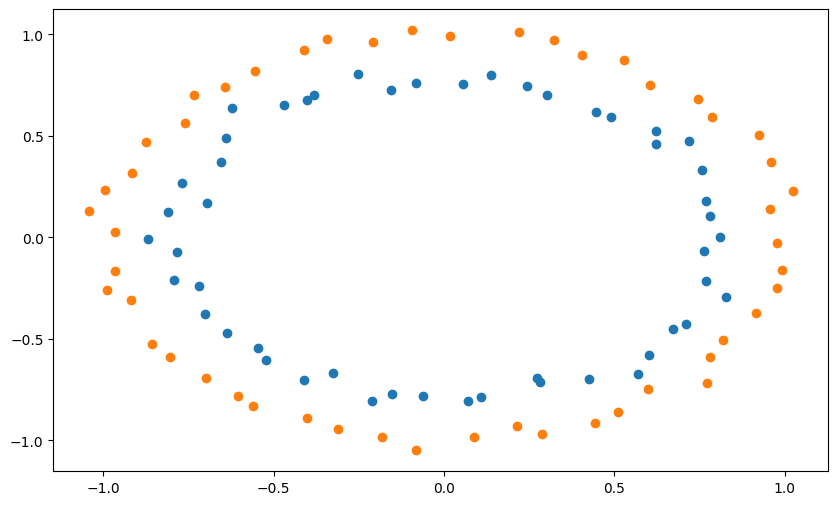

In [2]:
from sklearn.datasets import make_circles

N = 100
d = 2
X, t = make_circles(n_samples=N, noise = 0.03, random_state=42)

plt.figure(figsize=(10, 6))
plt.scatter(X[t==1, 0], X[t==1, 1])
plt.scatter(X[t==0, 0], X[t==0, 1])
plt.show()

**Q:** Split the data into a training and test set (80/20). Make sure to call them `X_train, X_test, t_train, t_test`.

In [3]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2)

## Class definition

The neural network is entirely defined by its parameters, i.e. the weight matrices and bias vectors, as well the transfer function of the hidden neurons. In order to make your code more reusable, the MLP will be implemented as a Python class. The following cell defines the class, but we will explain it step by step afterwards.

In [5]:
class MLP:

    def __init__(self, d, K, activation_function, max_val, eta):

        self.d = d
        self.K = K
        self.activation_function = activation_function
        self.eta = eta

        self.W1  = rng.uniform(-max_val, max_val, (K, d))
        self.b1  = rng.uniform(-max_val, max_val, (K, 1))

        self.W2 = rng.uniform(-max_val, max_val, (1, K))
        self.b2 = rng.uniform(-max_val, max_val, (1, 1))

    def feedforward(self, x):

        # Make sure x has 2 rows
        x = np.array(x).reshape((self.d, -1))

        # Hidden layer
        self.h = self.activation_function(np.dot(self.W1, x) + self.b1)

        # Output layer
        self.y = logistic(np.dot(self.W2, self.h) + self.b2)


    def train(self, X_train, t_train, nb_epochs, visualize=True):
        errors = []

        for epoch in range(nb_epochs):

            nb_errors = 0

            # Epoch
            for i in range(X_train.shape[0]):

                # Feedforward pass: sets self.h and self.y
                self.feedforward(X_train[i, :])

                # Backpropagation
                self.backprop(X_train[i, :], t_train[i])

                # Predict the class:
                if self.y[0, 0] > 0.5:
                    c = 1
                else:
                    c = 0

                # Count the number of misclassifications
                if t_train[i] != c:
                    nb_errors += 1

            # Compute the error rate
            errors.append(nb_errors/X_train.shape[0])

            # Plot the decision function every 10 epochs
            if epoch % 10 == 0 and visualize:
                self.plot_classification()

            # Stop when the error rate is 0
            if nb_errors == 0:
                if visualize:
                    self.plot_classification()
                break

        return errors, epoch+1

    def backprop(self, x, t):

        # Make sure x has 2 rows
        x = np.array(x).reshape((self.d, -1))

        # TODO: implement backpropagation

    def test(self, X_test, t_test):

        nb_errors = 0
        for i in range(X_test.shape[0]):

            # Feedforward pass
            self.feedforward(X_test[i, :])

            # Predict the class:
            if self.y[0, 0] > 0.5:
                c = 1
            else:
                c = 0

            # Count the number of misclassifications
            if t_test[i] != c:
                nb_errors += 1

        return nb_errors/X_test.shape[0]

    def plot_classification(self):

        # Allow redrawing
        clear_output(wait=True)

        x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
        y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

        x1 = xx.ravel()
        x2 = yy.ravel()
        x = np.array([[x1[i], x2[i]] for i in range(x1.shape[0])])

        self.feedforward(x.T)
        Z = self.y.copy()
        Z[Z>0.5] = 1
        Z[Z<=0.5] = 0

        from matplotlib.colors import ListedColormap
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

        fig = plt.figure(figsize=(10, 6))
        plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm_bright, alpha=.4)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, cmap=cm_bright, edgecolors='k')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=t_test, cmap=cm_bright, alpha=0.4, edgecolors='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()

The constructor `__init__` of the class accepts several arguments:

* `d` is the number inputs, here 2.
* `K` is the number of hidden neurons.
* `activation_function` is the function to use for the hidden neurons, for example the `logistic` function defined at the beginning of the notebook. Note that the name of the method can be stored as a variable.
* `max_val` is the maximum value used to initialize the weight matrices.
* `eta` is the learning rate.

The constructor starts by saving these arguments as attributes, so that they can be used in other method as `self.K`:

```python
def __init__(self, d, K, activation_function, max_val, eta):

    self.d = d
    self.K = K
    self.activation_function = activation_function
    self.eta = eta
```

The constructor then initializes randomly the weight matrices and bias vectors, uniformly between `-max_val` and `max_val`.

```python
self.W1  = rng.uniform(-max_val, max_val, (K, d))
self.b1  = rng.uniform(-max_val, max_val, (K, 1))

self.W2 = rng.uniform(-max_val, max_val, (1, K))
self.b2 = rng.uniform(-max_val, max_val, (1, 1))
```

You can then already create the `MLP` object and observe how the parameters are initialized:

```python
mlp = MLP(d=2, K=15, activation_function=logistic, max_val=1.0, eta=0.05)
```

**Q:** Create the object and print the weight matrices and bias vectors.

In [9]:
mlp = MLP(d=2, K=15, activation_function=logistic, max_val=1.0, eta=0.05)
print(mlp.W1)

[[-0.51220676  0.35612393]
 [-0.65112776  0.26384441]
 [ 0.82475354  0.98977542]
 [ 0.17584464  0.40852654]
 [-0.56707268  0.97927228]
 [ 0.06871901 -0.21113963]
 [ 0.5784675  -0.563401  ]
 [-0.53370762 -0.61684555]
 [ 0.96605263 -0.2460779 ]
 [ 0.5734104  -0.16337957]
 [-0.24722528 -0.88366593]
 [-0.23167786  0.23196365]
 [ 0.98581072 -0.05848716]
 [ 0.80686382  0.11231477]
 [ 0.08274609  0.42146724]]


The `feedforward` method takes a vector `x` as input, reshapes it to make sure it has two rows, and computes the hidden activation $\mathbf{h}$ and the prediction $\mathbf{y}$.

```python
def feedforward(self, x):

    # Make sure x has 2 rows
    x = np.array(x).reshape((self.d, -1))

    # Hidden layer
    self.h = self.activation_function(np.dot(self.W1, x) + self.b1)

    # Output layer
    self.y = logistic(np.dot(self.W2, self.h) + self.b2)
```

Notice the use of `self.` to access attributes, as well as the use of `np.dot()` to mulitply vectors and matrices.

**Q:** Using the randomly initialized weights, apply the `feedforward()` method to an input vector (for example $[0.5, 0.5]$) and print `h` and `y`. What is the predicted class of the example?

In [10]:
mlp.feedforward([0.5, 0.5])
print(mlp.h)
print(mlp.y)

# prediction is, that's it's a positive class

[[0.59006196]
 [0.30619015]
 [0.49027371]
 [0.62793248]
 [0.37597743]
 [0.59359607]
 [0.33230762]
 [0.32030558]
 [0.42668087]
 [0.53992822]
 [0.28867942]
 [0.35966629]
 [0.53716734]
 [0.65061296]
 [0.43387576]]
[[0.64091771]]


The class also provides a visualization method. It is not import to understand the code for the exercise, so you can safely skip it. It displays the training data as plain points, the test data as semi-transparent points and displays the decision function as a background color (all points in the blue region will be classified as negative examples).

**Q:** Plot the initial classification on the dataset with random weights. Is there a need for learning? Reinitialize the weights and biases multiple times. What do you observe?

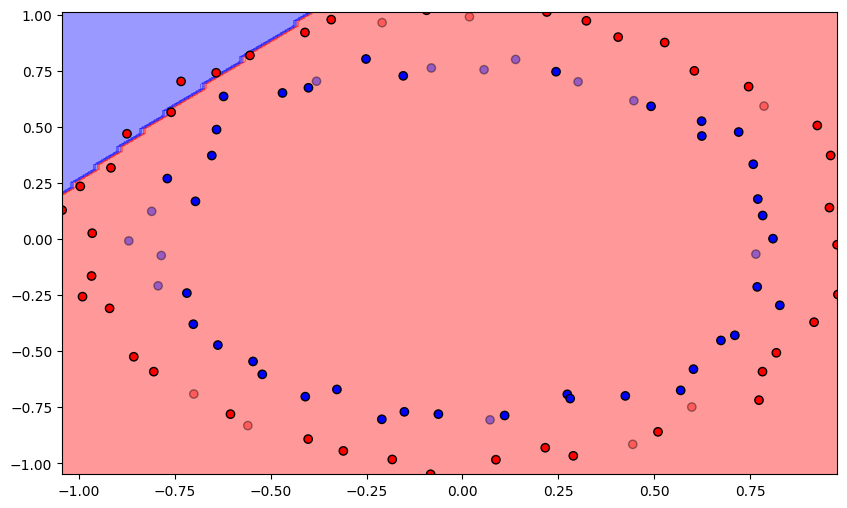

In [16]:
mlp = MLP(d=2, K=15, activation_function=logistic, max_val=1.0, eta=0.05)

mlp.plot_classification()

# most of the time everthing is red, but sometimes there is a blue line cutting the view into 2 pieces by forming a triangle with the edges

## Backpropagation

The `train()` method implements the training loop you have already implemented several times: several epochs over the training set, making a prediction for each input and modifying the parameters according to the prediction error:

```python
def train(self, X_train, t_train, nb_epochs, visualize=True):
    errors = []

    for epoch in range(nb_epochs):

        nb_errors = 0

        # Epoch
        for i in range(X_train.shape[0]):

            # Feedforward pass: sets self.h and self.y
            self.feedforward(X_train[i, :])

            # Backpropagation
            self.backprop(X_train[i, :], t_train[i])

            # Predict the class:         
            if self.y[0, 0] > 0.5:
                c = 1
            else:
                c = 0

            # Count the number of misclassifications
            if t_train[i] != c:
                nb_errors += 1

        # Compute the error rate
        errors.append(nb_errors/X_train.shape[0])

        # Plot the decision function every 10 epochs
        if epoch % 10 == 0 and visualize:
            self.plot_classification()

        # Stop when the error rate is 0
        if nb_errors == 0:
            if visualize:
                self.plot_classification()
            break

    return errors, epoch+1
```

The training methods stops after `nb_epochs` epochs or when no error is made during the last epoch. The decision function is visualized every 10 epochs to better understand what is happening. The method returns a list containing the error rate after each epoch, as well as the number of epochs needed to reach an error rate of 0.

The only thing missing is the `backprop(x, t)` method, which currently does nothing:

```python
def backprop(self, x, t):

    # Make sure x has 2 rows
    x = np.array(x).reshape((self.d, -1))

    # TODO: implement backpropagation
```

**Q:**  Implement the *online* backpropagation algorithm.

All you have to do is to backpropagate the output error and adapt the parameters using the delta learning rule:

1. compute the output error `delta`.
2. compute the backpropagated error `delta_hidden`.
3. increment the parameters `self.W1, self.b1, self.W2, self.b2` accordingly.

The only difficulty is to take care of the shape of each matrix (before multiplying two matrices or vectors, test what their shape is).

*Note:* you can either edit directly the cell containing the definition of the class, or create a new class `TrainableMLP` inheriting from the class `MLP` and simply redefine the `backprop()` method. The solution will use the second option to be more readable, but it does not matter.

In [52]:
class TrainableMLP:

    def __init__(self, d, K, activation_function, max_val, eta):

        self.d = d
        self.K = K
        self.activation_function = activation_function
        self.eta = eta

        self.W1  = rng.uniform(-max_val, max_val, (K, d))
        self.b1  = rng.uniform(-max_val, max_val, (K, 1))

        self.W2 = rng.uniform(-max_val, max_val, (1, K))
        self.b2 = rng.uniform(-max_val, max_val, (1, 1))

    def feedforward(self, x):

        # Make sure x has 2 rows
        x = np.array(x).reshape((self.d, -1))

        # Hidden layer
        self.h = self.activation_function(np.dot(self.W1, x) + self.b1)

        # Output layer
        self.y = logistic(np.dot(self.W2, self.h) + self.b2)


    def train(self, X_train, t_train, nb_epochs, visualize=True):
        errors = []

        for epoch in range(nb_epochs):

            nb_errors = 0

            # Epoch
            for i in range(X_train.shape[0]):

                # Feedforward pass: sets self.h and self.y
                self.feedforward(X_train[i, :])

                # Backpropagation
                self.backprop(X_train[i, :], t_train[i])

                # Predict the class:
                if self.y[0, 0] > 0.5:
                    c = 1
                else:
                    c = 0

                # Count the number of misclassifications
                if t_train[i] != c:
                    nb_errors += 1

            # Compute the error rate
            errors.append(nb_errors/X_train.shape[0])

            # Plot the decision function every 10 epochs
            if epoch % 10 == 0 and visualize:
                self.plot_classification()

            # Stop when the error rate is 0
            if nb_errors == 0:
                if visualize:
                    self.plot_classification()
                break

        return errors, epoch+1

    def backprop(self, x, t):

        # Make sure x has 2 rows
        x = np.array(x).reshape((self.d, -1))
        h = self.activation_function(np.dot(self.W1, x) + self.b1)

        # Print the shapes
        '''
        print("t: " + str(t.shape))
        print("t-Werte: " + str(t))
        print("y: " + str(self.y.shape))
        print("h: " + str(h.shape))
        print("x: " + str(x.shape))

        print("W_1: " + str(self.W1.shape))
        print("b_1: " + str(self.b1.shape))

        print("W_2: " + str(self.W2.shape))
        print("W_2: " + str(self.b2.shape))
        '''
        # Compute output error delta
        delta = t - self.y

        # Compute the backpropagated error delta_hidden
        delta_hidden = self.h * (1 - self.h) * (self.W2.T * delta)

        # Increment parameters
        self.W1 += self.eta * delta_hidden * x.T
        self.b1 += self.eta * delta_hidden
        self.W2 += self.eta * delta * self.h.T
        self.b2 += self.eta * delta

    def test(self, X_test, t_test):

        nb_errors = 0
        for i in range(X_test.shape[0]):

            # Feedforward pass
            self.feedforward(X_test[i, :])

            # Predict the class:
            if self.y[0, 0] > 0.5:
                c = 1
            else:
                c = 0

            # Count the number of misclassifications
            if t_test[i] != c:
                nb_errors += 1

        return nb_errors/X_test.shape[0]

    def plot_classification(self):

        # Allow redrawing
        clear_output(wait=True)

        x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
        y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

        x1 = xx.ravel()
        x2 = yy.ravel()
        x = np.array([[x1[i], x2[i]] for i in range(x1.shape[0])])

        self.feedforward(x.T)
        Z = self.y.copy()
        Z[Z>0.5] = 1
        Z[Z<=0.5] = 0

        from matplotlib.colors import ListedColormap
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

        fig = plt.figure(figsize=(10, 6))
        plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm_bright, alpha=.4)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, cmap=cm_bright, edgecolors='k')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=t_test, cmap=cm_bright, alpha=0.4, edgecolors='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()

**Q:** Train the MLP for 1000 epochs on the data using a learning rate of 0.05, 15 hidden neurons and weights initialized between -1 and 1. Plot the evolution of the training error.

In [62]:
mlp_train = TrainableMLP(d=2, K=15, activation_function=logistic, max_val=1.0, eta=0.05)

# Feedforward pass: sets self.h and self.y
# mlp_train.feedforward(X_train[0, :])

# Backpropagation
# mlp_train.backprop(X_train[1, :], t_train[1])

res = mlp_train.train(X_train, t_train, 1000, False)
# mlp_train.plot_classification()

**Q:** Use the `test()` method to compute the error on the test set. What is the test accuracy of your network after training? Compare it to the training accuracy.

In [54]:
mlp_train.test(X_test, t_test)

# beide 0

0.0

## Experiments

### Influence of the number of hidden neurons

**Q:** Try different values for the number of hidden neurons $K$ (e.g. 2, 5, 10, 15, 20, 25, 50...) and observe how the accuracy and speed of convergence evolve.

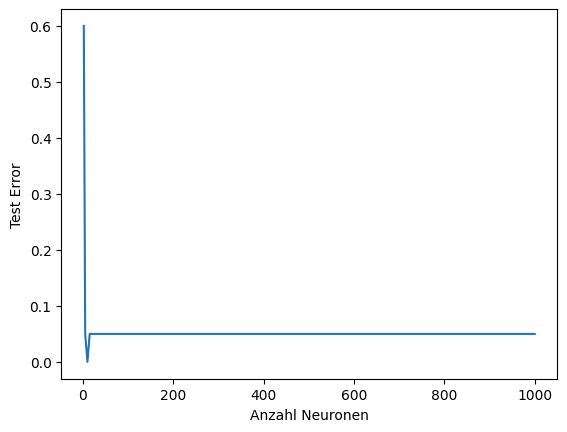

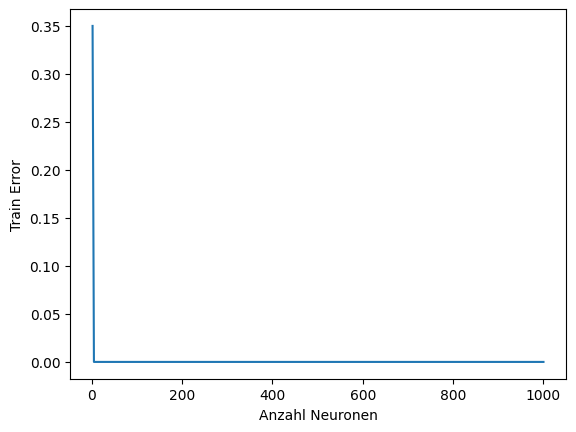

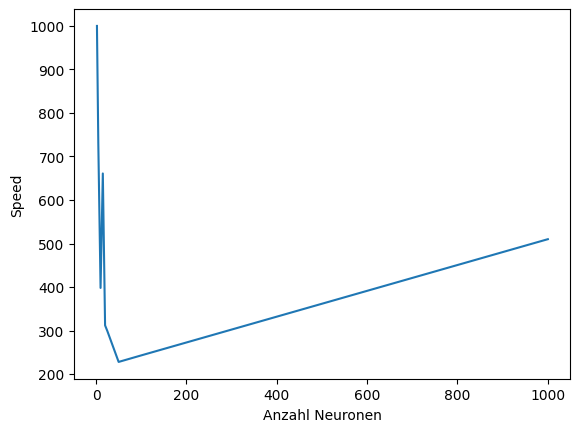

In [72]:
nb_neurons = [2, 5, 10, 15, 20, 25, 50, 100, 1000]

train_error = []
test_error = []
speed = []

for k in nb_neurons:
  mlp_train = TrainableMLP(d=2, K=k, activation_function=logistic, max_val=1.0, eta=0.05)

  # Feedforward pass: sets self.h and self.y
  # mlp_train.feedforward(X_train[0, :])

  # Backpropagation
  # mlp_train.backprop(X_train[1, :], t_train[1])
  res = mlp_train.train(X_train, t_train, 1000, False)
  train_error.append(res[0][-1])
  speed.append(res[1])
  test_error.append(mlp_train.test(X_test, t_test))

# plot test_error
plt.plot(nb_neurons, test_error)
plt.xlabel("Anzahl Neuronen")
plt.ylabel("Test Error")
plt.show()

# plot train_error
plt.plot(nb_neurons, train_error)
plt.xlabel("Anzahl Neuronen")
plt.ylabel("Train Error")
plt.show()

# plot the speed of convergence
plt.plot(nb_neurons, speed)
plt.xlabel("Anzahl Neuronen")
plt.ylabel("Speed")
plt.show()

### Influence of the learning rate

**Q:** Vary the learning rate between extreme values. How does the performance evolve?

### Influence of weight initialization

**Q:** The weights are initialized randomly between -1 and 1. Try to initialize them to 0. Does it work? Why?

**Q:** For a fixed number of hidden neurons (e.g. $K=15$) and a correct value of `eta`, train 10 times the network with different initial weights and superimpose on the same plot the evolution of the training error. Conclude.

### Influence of the transfer function

**Q:** Modify the `backprop()` method so that it applies backpropagation correctly for any of the four activation functions:

* linear
* logistic
* tanh
* relu

In [ ]:
# Linear transfer function
def linear(x):
    return x

# tanh transfer function
def tanh(x):
    return np.tanh(x)

# ReLU transfer function
def relu(x):
    x = x.copy()
    x[x < 0.] = 0.
    return x

Remember that the derivatives of these activations functions are easy to compute:

* linear: $f'(x) = 1$
* logistic: $f'(x) = f(x) \, (1 - f(x))$
* tanh: $f'(x) = 1 - f^2(x)$
* relu: $f'(x) = \begin{cases}1 \; \text{if} \; x>0\\ 0 \; \text{if} \; x \leq 0\\ \end{cases}$

*Hint:* `activation_function` is a variable like others, although it is the name of a method. You can apply comparisons on it:

```python
if self.activation_function == linear:
    diff = something
elif self.activation_function == logistic:
    diff = something
elif self.activation_function == tanh:
    diff = something
elif self.activation_function == relu:
    diff = something
```

**Q:** Use a linear transfer function for the hidden neurons. How does performance evolve? Is the non-linearity of the transfer function important for learning?

**Q:** Use this time the hyperbolic tangent function as a transfer function for the hidden neurons. Does it improve learning?

**Q:** Use the Rectified Linear Unit (ReLU) transfer function. What does it change? Conclude on the importance of the transfer function for the hidden neurons. Select the best one from now on.

### Influence of data normalization

The input data returned by `make_circles` is nicely center around 0, with values between -1 and 1. What happens if this is not the case with your data?

**Q:** Shift the input data `X` using the formula:

$$X_\text{shifted} = 8 \, X + 2$$

regenerate the training and test sets and train the MLP on them. What do you observe?

**Q:** Normalize the shifted data so that it has a mean of 0 and a variance of 1 in each dimension, using the formula:

$$X_\text{normalized} = \dfrac{X_\text{shifted} - \text{mean}(X_\text{shifted})}{\text{std}(X_\text{shifted})}$$

and retrain the network. Conclude.

### Influence of randomization

The training loop we used until now iterated over the training samples in the exact same order at every epoch. The samples are therefore not i.i.d (independent and identically distributed) as they follow the same sequence.

**Q:** Modify the `train()` method so that the indices of the training samples are randomized between two epochs. Check the doc of `rng.permutation()` for help.

### Influence of weight initialization - part 2

According to the empirical analysis by Glorot and Bengio in “Understanding the difficulty of training deep feedforward neural networks”, the optimal initial values for the weights between two layers of a MLP are uniformly taken in the range:

$$
    \mathcal{U}( - \sqrt{\frac{6}{N_{\text{in}}+N_{\text{out}}}} , \sqrt{\frac{6}{N_{\text{in}}+N_{\text{out}}}} )
$$

where $N_{\text{in}}$ is the number of neurons in the first layer and $N_{\text{out}}$ the number of neurons in the second layer.

**Q:** Modify the constructor of your class to initialize both hidden and output weights with this new range. The biases should be initialized to 0. What is the effect?

### Summary

**Q:** Now that we optimized the MLP, it is time to cross-validate again the number of hidden neurons and the learning rate. As the networks always get a training error rate of 0 and the test set is not very relevant, the maincriteria will be the number of epochs needed on average to converge. Find the best MLP for the dataset (there is not a single solution), for example by iterating over multiple values of `K` and `eta`. What do you think of the change in performance between the first naive implementation and the final one? What were the most critical changes?